# Fine-Tuning BERT on GLUE - RTE

From [ACLweb](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment):

Textual Entailment Recognition has been proposed recently as a generic task that captures major semantic inference needs across many NLP applications, such as Question Answering, Information Retrieval, Information Extraction, and Text Summarization. This task requires to recognize, given two text fragments, whether the meaning of one text is entailed (can be inferred) from the other text. 

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
from pathlib import Path

import numpy as np
from transformers import set_seed

# RANDOMNESS SEED
SEED = 21
set_seed(SEED)
np.random.seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "rte"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA A40

==============NVSMI LOG==============

Timestamp                                 : Wed Jan 15 22:19:43 2025
Driver Version                            : 550.90.07
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:08:00.0
    FB Memory Usage
        Total                             : 46068 MiB
        Reserved                          : 665 MiB
        Used                              : 13365 MiB
        Free                              : 32039 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 4 MiB
        Free                              : 65532 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## 1. Dataset

In [5]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [6]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [7]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence1,sentence2,label,idx
1524,"The widow of John Lennon, Yoko Ono, may take l...",Yoko Ono is John Lennon's widow.,0,1524
127,Swiss police confirmed Thursday that cult lead...,Luc Jouret was the leader of the Order of the ...,1,127
1410,Scientists had thought all gamma-ray bursts ha...,The scientists had thought that all explosions...,1,1410
1532,"Shelby Foote, author of the acclaimed three vo...",The Civil War: A Narrative is a book written b...,0,1532
826,"Valero Energy Corp., on Monday, said it found ...",Valero Energy Corp. caused damages to Port Art...,1,826
853,Hurricane Katrina petroleum-supply outlook imp...,"Offers by individual European governments, inv...",0,853
1739,The launch of France's new 24 hour TV news cha...,France24 is a French TV Channel.,0,1739
1388,"The Sears Tower in Chicago, finished in 1974, ...",The Sears Tower has 110 stories.,0,1388
72,Most people are familiar with the idea of St. ...,Robots are used to find missing victims.,0,72
938,"Co-producing the film is Happy Madison, the co...",Happy Madison works for the company owned by S...,1,938


In [8]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0])
num_labels=2


The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [9]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
975,DePrisco is the third Canadian who has recentl...,Nancy Ianiero was killed in Mexico.,-1,975
472,Blondlot was trying to polarize X-rays when he...,Blondlot discovered x-rays.,-1,472
2684,"According to the DNC chairman Howard Dean, Sen...",Bill Clinton used to be President of the Unite...,-1,2684
397,When Aki Kaurismaki stood up at the awards cer...,Aki Kaurismaki directed a film.,-1,397
2106,Researchers have found evidence that some peop...,Researchers have found that some people inheri...,-1,2106
434,Only three buildings were wrapped by Christo: ...,The Valley Curtain was wrapped by Christo.,-1,434
1278,Bush returned home as a war hero. He married B...,The name of George H.W. Bush's wife is Barbara.,-1,1278
84,In announcing plans today to prepare the natio...,President Bush plans a confrontation with glob...,-1,84
1602,"The national insurrection of 1794, led by Tade...",Warsaw became a town in Prussia.,-1,1602
408,"The Channel Tunnel, thirty-two miles in length...",The Channel Tunnel connects France and Japan.,-1,408


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [10]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.1)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2241
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 249
    })
})

In [11]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2241
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 249
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [12]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
155,"""I just hope I don't become so blissful I beco...","""Smells Like Teen Spirit"" is a song by Nirvana.",1,1994
192,Japanese drug makers are now trying to build c...,There are companies that have split the manage...,1,2278
164,Some of the buildings around the city square i...,"In the Old City are the old port, the Dutch to...",1,1988
223,"Bogota, 4 May 88 - The dissemination of a docu...",The Army Of National Liberation are supporters...,0,2183
47,The ghost shirt was then donated to the Glasgo...,A Sioux ghost shirt was returned by a Scottish...,0,230
200,Bosnia's leading Muslim daily Dnevni Avaz writ...,Europe's first pyramid has been discovered nea...,0,1596
163,"Because of Reagan's economic strategy, the fed...",Reagan's economic strategy led to huge federal...,0,914
149,A Belgian policeman posing as an art dealer in...,Three Swedes were arrested in a Belgian police...,0,1820
146,With the publication of Sophie's World in 1991...,Sophie's World is a best seller.,0,171
19,"Yount, who was living in Coeur under the alias...",James Marvin Forsgren killed Pamela Sue Rimer.,0,2473


## 2. BERT-base

In [13]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [15]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 289
Max length in split='validation': 253
Max length in split='test': 210


In [16]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Here is an example of a tokenized dataset item:

In [17]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
sentence1,Some passengers were escorted off the ship in wheelchairs by crew wearing blue gloves.
sentence2,Wheelchairs were used to lead passengers off the ship.
label,0
idx,1307
input_ids,"[101, 2070, 5467, 2020, 13127, 2125, 1996, 2911, 1999, 13204, 2015, 2011, 3626, 4147, 2630, 11875, 1012, 102, 13204, 2015, 2020, 2109, 2000, 2599, 5467, 2125, 1996, 2911, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,101,2070,5467,2020,13127,2125,1996,2911,1999,13204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,2665,2154,1010,2040,3369,2012,1996,6891,1999,...,2665.0,2154.0,1010.0,2165.0,2188.0,2698.0,4231.0,3549.0,1012.0,102.0
2,101,2149,2343,2577,1059,1012,5747,2038,5393,2002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,101,2070,5467,2020,13127,2125,1996,2911,1999,13204,...,0,0,0,0,0,0,0,0,0,0
1,101,2665,2154,1010,2040,3369,2012,1996,6891,1999,...,2665,2154,1010,2165,2188,2698,4231,3549,1012,102
2,101,2149,2343,2577,1059,1012,5747,2038,5393,2002,...,0,0,0,0,0,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [20]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [21]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [22]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task rte


In [23]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [24]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [26]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":  # STSB is the odd one as it is a regression task
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [28]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-rte/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693400,0.667122,0.610108
2,0.614800,0.629623,0.653430
3,0.466200,0.707318,0.638989
4,0.342100,0.764825,0.642599
5,0.265700,0.802919,0.642599


In [29]:
training_summary_bert_base

TrainOutput(global_step=355, training_loss=0.4764504875935299, metrics={'train_runtime': 94.9089, 'train_samples_per_second': 118.061, 'train_steps_per_second': 3.74, 'total_flos': 1057833886964640.0, 'train_loss': 0.4764504875935299, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [30]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.6296225786209106,
 'eval_accuracy': 0.6534296028880866,
 'eval_runtime': 0.6552,
 'eval_samples_per_second': 422.789,
 'eval_steps_per_second': 13.737,
 'epoch': 5.0}

In [31]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.6934,25.290627,0.000016,71,0.667122,0.610108,0.6598,419.802,13.640,NaN,NaN,NaN,NaN,NaN
2,0.6148,30.135164,0.000012,142,0.629623,0.653430,0.6604,419.419,13.627,NaN,NaN,NaN,NaN,NaN
3,0.4662,12.940859,0.000008,213,0.707318,0.638989,0.6619,418.499,13.597,NaN,NaN,NaN,NaN,NaN
4,0.3421,42.719051,0.000004,284,0.764825,0.642599,0.6627,418.010,13.582,NaN,NaN,NaN,NaN,NaN
5,0.2657,12.991739,0.000000,355,0.802919,0.642599,0.6604,419.427,13.628,94.9089,118.061,3.74,1.057834e+15,0.47645


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-base-uncased)

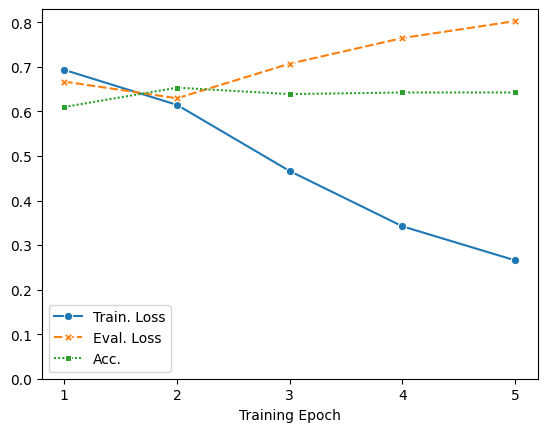

In [32]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

**Note:** For some reason this plot seems awry. The accuracy metric is hardly improving, while evaluation loss increases over training. It seems that fine-tuning on this tasks always results in overfitting.  
One reason might be that this GLUE task has by far the smallest dataset.

### 2.4 Evaluation

### Label frequency in test dataset

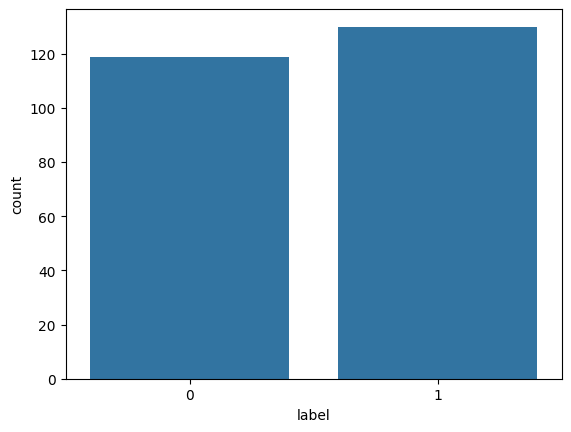

In [33]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in test dataset"))

The dataset classes seem to be somewhat balanced.

In [34]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-base-uncased)

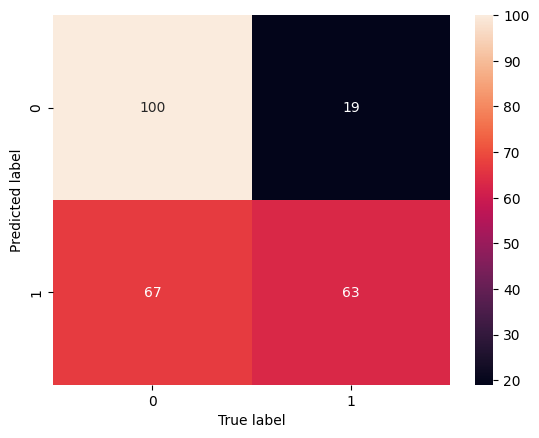

In [35]:
import sklearn.metrics

bert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [36]:
predictions.metrics

{'test_loss': 0.6195610761642456,
 'test_accuracy': 0.6546184738955824,
 'test_runtime': 0.5852,
 'test_samples_per_second': 425.496,
 'test_steps_per_second': 13.671}

In [37]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [predictions.metrics["test_accuracy"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_accuracy"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-",0.664]
results["original BERT_LARGE"] = ["-", "-","-", 0.701]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,94.908900,-,-
eval_loss,0.629623,-,-
eval_accuracy,0.653430,-,-
test_accuracy,0.654618,0.664,0.701


## 3. BERT-Large

In [38]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

In [40]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [41]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task rte


In [42]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [43]:
BATCH_SIZE = 32  # BERT-large might need a smaller batch size

In [44]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

3350

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-rte/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705000,0.666637,0.602888
2,0.597600,0.596381,0.707581
3,0.457700,0.625003,0.685921
4,0.329400,0.765349,0.671480
5,0.205700,0.852510,0.685921


In [47]:
training_summary_bert_large

TrainOutput(global_step=355, training_loss=0.4590932658020879, metrics={'train_runtime': 290.6759, 'train_samples_per_second': 38.548, 'train_steps_per_second': 1.221, 'total_flos': 3746815484832672.0, 'train_loss': 0.4590932658020879, 'epoch': 5.0})

In [48]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.5963811874389648,
 'eval_accuracy': 0.7075812274368231,
 'eval_runtime': 2.0654,
 'eval_samples_per_second': 134.115,
 'eval_steps_per_second': 4.358,
 'epoch': 5.0}

In [49]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.7050,27.192032,0.000016,71,0.666637,0.602888,2.0802,133.160,4.326,NaN,NaN,NaN,NaN,NaN
2,0.5976,91.258949,0.000012,142,0.596381,0.707581,2.0822,133.035,4.322,NaN,NaN,NaN,NaN,NaN
3,0.4577,14.319281,0.000008,213,0.625003,0.685921,2.0815,133.074,4.324,NaN,NaN,NaN,NaN,NaN
4,0.3294,64.455406,0.000004,284,0.765349,0.671480,2.0826,133.009,4.322,NaN,NaN,NaN,NaN,NaN
5,0.2057,45.333847,0.000000,355,0.852510,0.685921,2.0720,133.685,4.344,290.6759,38.548,1.221,3.746815e+15,0.459093


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

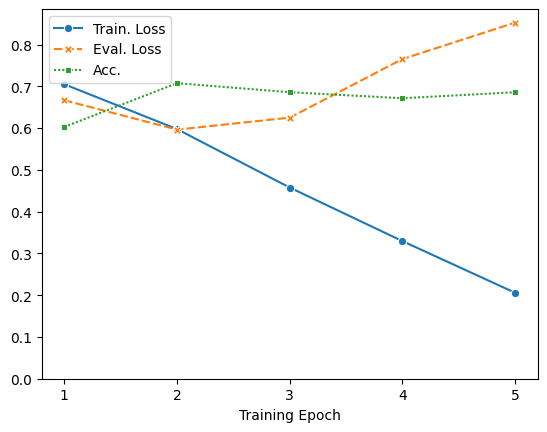

In [50]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [51]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-large-uncased)

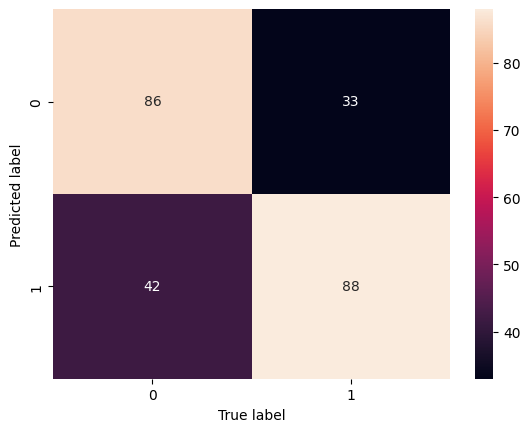

In [52]:
import sklearn.metrics

bert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [53]:
predictions.metrics

{'test_loss': 0.5841096043586731,
 'test_accuracy': 0.6987951807228916,
 'test_runtime': 1.8539,
 'test_samples_per_second': 134.308,
 'test_steps_per_second': 4.315}

In [54]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,94.908900,-,290.675900,-
eval_loss,0.629623,-,0.596381,-
eval_accuracy,0.653430,-,0.707581,-
test_accuracy,0.654618,0.664,0.698795,0.701


## 4. ModernBERT-base

In [55]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [56]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

In [57]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [58]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task rte


In [59]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [60]:
BATCH_SIZE = 32

In [61]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

9792

In [62]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-rte/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.757400,0.709097,0.476534
2,0.682800,0.729289,0.555957
3,0.478500,0.735676,0.574007
4,0.184100,1.418598,0.555957
5,0.070300,2.420499,0.552347


In [64]:
training_summary_modernbert_base

TrainOutput(global_step=355, training_loss=0.43462021115800026, metrics={'train_runtime': 73.2692, 'train_samples_per_second': 152.929, 'train_steps_per_second': 4.845, 'total_flos': 1395910522948536.0, 'train_loss': 0.43462021115800026, 'epoch': 5.0})

In [65]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.735160768032074,
 'eval_accuracy': 0.5776173285198556,
 'eval_runtime': 0.3899,
 'eval_samples_per_second': 710.455,
 'eval_steps_per_second': 23.083,
 'epoch': 5.0}

In [66]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.7574,7.231557,0.000064,71,0.709097,0.476534,0.5305,522.135,16.965,NaN,NaN,NaN,NaN,NaN
2,0.6828,4.996901,0.000048,142,0.729289,0.555957,0.4379,632.624,20.555,NaN,NaN,NaN,NaN,NaN
3,0.4785,26.211588,0.000032,213,0.735676,0.574007,0.3942,702.764,22.833,NaN,NaN,NaN,NaN,NaN
4,0.1841,10.308813,0.000016,284,1.418598,0.555957,0.3927,705.403,22.919,NaN,NaN,NaN,NaN,NaN
5,0.0703,0.379395,0.000000,355,2.420499,0.552347,0.3996,693.232,22.524,73.2692,152.929,4.845,1.395911e+15,0.43462


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

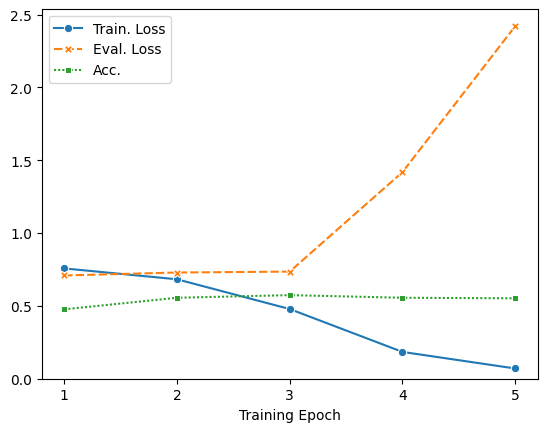

In [67]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [68]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-base)

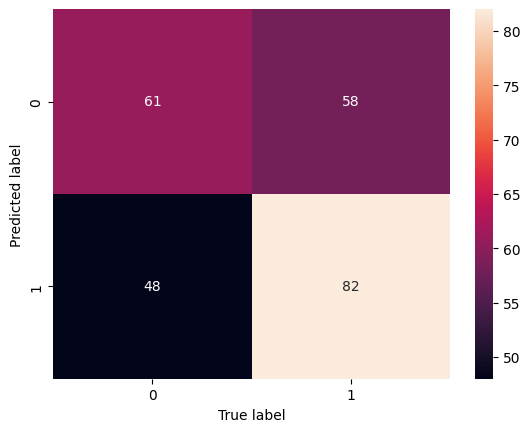

In [69]:
import sklearn.metrics

modernbert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [70]:
predictions.metrics

{'test_loss': 0.7508520483970642,
 'test_accuracy': 0.5742971887550201,
 'test_runtime': 0.3433,
 'test_samples_per_second': 725.337,
 'test_steps_per_second': 23.304}

In [71]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,94.908900,-,73.269200,290.675900,-
eval_loss,0.629623,-,0.735161,0.596381,-
eval_accuracy,0.653430,-,0.577617,0.707581,-
test_accuracy,0.654618,0.664,0.574297,0.698795,0.701


## 5. ModernBERT-Large

In [72]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [73]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

In [74]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [75]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task rte


In [76]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [77]:
BATCH_SIZE = 32

In [78]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [79]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-rte/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.773000,0.699977,0.552347
2,0.697100,0.709090,0.545126
3,0.640100,0.675690,0.566787
4,0.359300,0.817147,0.635379
5,0.107600,1.081429,0.682310


In [81]:
training_summary_modernbert_large

TrainOutput(global_step=355, training_loss=0.5154007898250096, metrics={'train_runtime': 161.4623, 'train_samples_per_second': 69.397, 'train_steps_per_second': 2.199, 'total_flos': 4332265805859768.0, 'train_loss': 0.5154007898250096, 'epoch': 5.0})

In [82]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 1.083884358406067,
 'eval_accuracy': 0.6787003610108303,
 'eval_runtime': 0.8009,
 'eval_samples_per_second': 345.844,
 'eval_steps_per_second': 11.237,
 'epoch': 5.0}

In [83]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.7730,12.980923,0.000064,71,0.699977,0.552347,0.9371,295.606,9.605,NaN,NaN,NaN,NaN,NaN
2,0.6971,5.317398,0.000048,142,0.709090,0.545126,0.8032,344.875,11.205,NaN,NaN,NaN,NaN,NaN
3,0.6401,25.385733,0.000032,213,0.675690,0.566787,0.7989,346.747,11.266,NaN,NaN,NaN,NaN,NaN
4,0.3593,14.035787,0.000016,284,0.817147,0.635379,0.9701,285.551,9.278,NaN,NaN,NaN,NaN,NaN
5,0.1076,0.102248,0.000000,355,1.081429,0.682310,0.8360,331.335,10.765,161.4623,69.397,2.199,4.332266e+15,0.515401


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

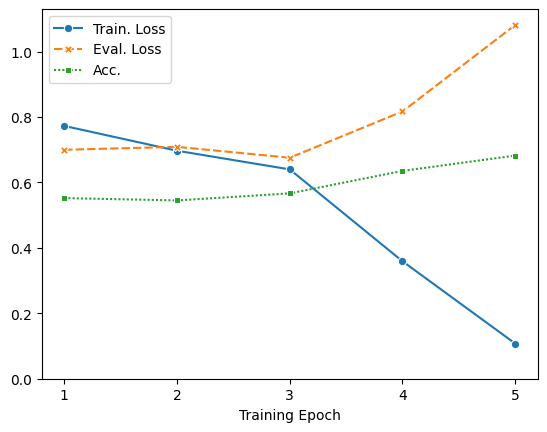

In [84]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [85]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-large)

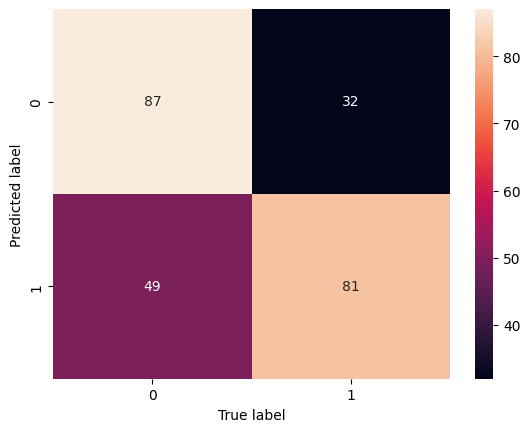

In [86]:
import sklearn.metrics

modernbert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [87]:
predictions.metrics

{'test_loss': 1.000483751296997,
 'test_accuracy': 0.6746987951807228,
 'test_runtime': 0.6865,
 'test_samples_per_second': 362.728,
 'test_steps_per_second': 11.654}

In [88]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,94.908900,-,73.269200,290.675900,-,161.462300
eval_loss,0.629623,-,0.735161,0.596381,-,1.083884
eval_accuracy,0.653430,-,0.577617,0.707581,-,0.678700
test_accuracy,0.654618,0.664,0.574297,0.698795,0.701,0.674699


# Summary

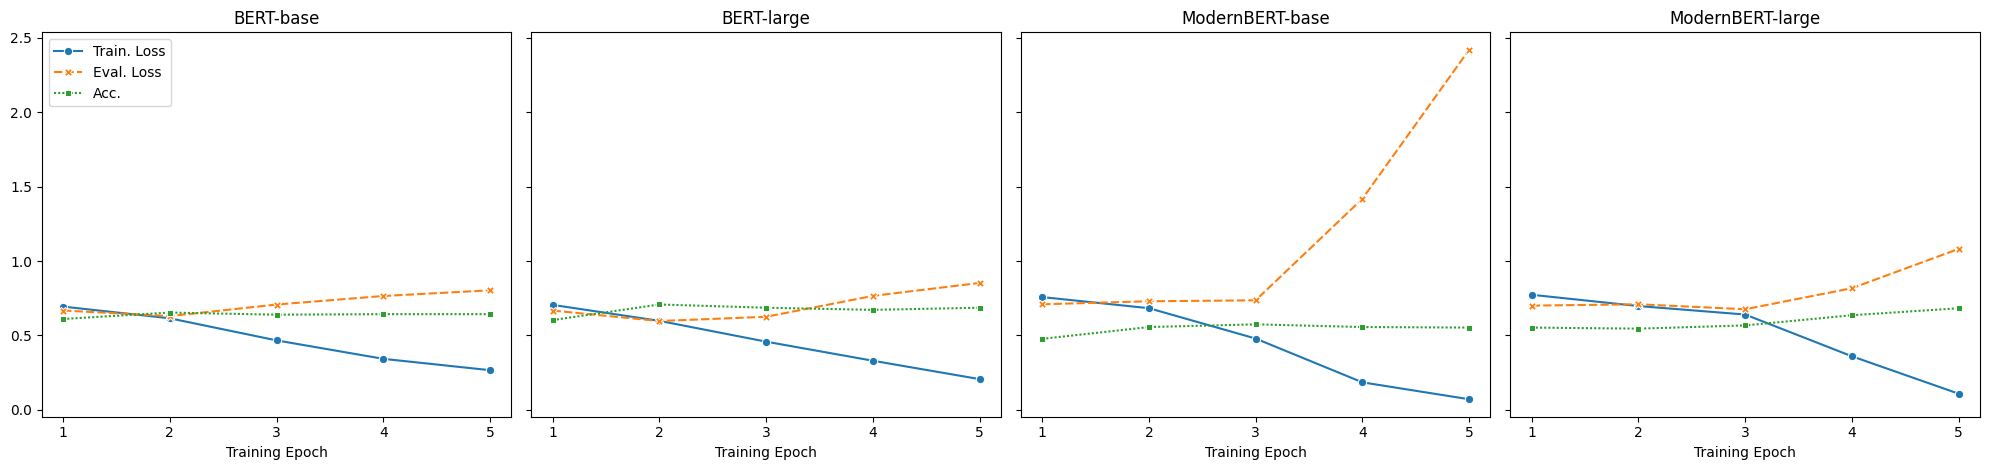

In [89]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

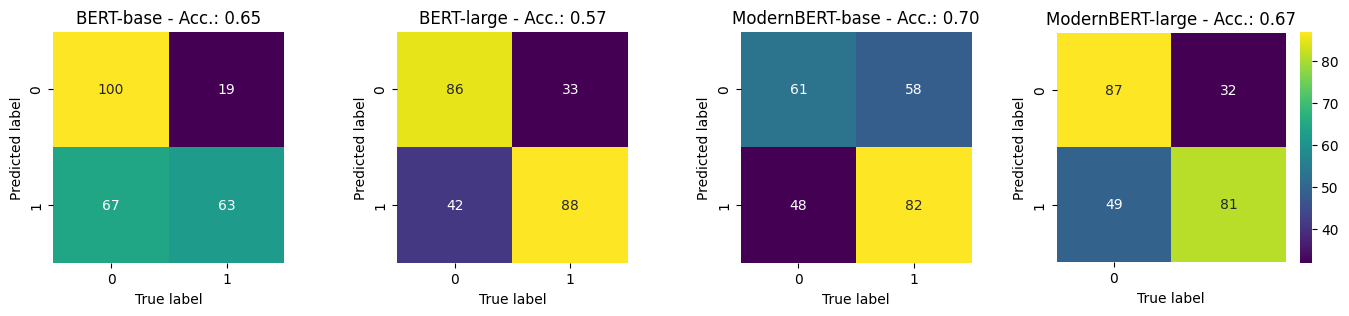

In [90]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
our_results = results.loc["test_accuracy"].drop("original BERT_BASE").drop("original BERT_LARGE")
titles = [title + " - " + f"Acc.: {acc:.2f}" for title, acc in zip(titles, our_results)]
cms = [bert_base_cm, bert_large_cm, modernbert_base_cm, modernbert_large_cm]

fig, axes = plt.subplots(ncols=len(cms),  figsize=(3,3))

def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title == titles[-1]
    plot = sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="viridis", cbar=include_cbar, ax=ax)
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)

for title, history, ax in zip(titles, cms, axes):
    draw_confusion_matrix_plot(title, history, ax)

fig.set_figwidth(17)

In [91]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,94.908900,-,73.269200,290.675900,-,161.462300
eval_loss,0.629623,-,0.735161,0.596381,-,1.083884
eval_accuracy,0.653430,-,0.577617,0.707581,-,0.678700
test_accuracy,0.654618,0.664,0.574297,0.698795,0.701,0.674699


In [92]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.2953451109060834)

Interestingly our `ModernBERT-base` model perform even worse than our `BERT-base` model. However this result could be an artifact, that vanishes with hyper-parameter tuning. Still the `ModernBERT-base` model provides a __1.29x speedup__ in training time compare to `BERT-base`.